# **DEMAND SIDE MANAGEMENT**


imports

In [89]:
import numpy as np
import random
import matplotlib.pyplot as plt

**Appliance Scheduler**

This class generates the unscheduled load profile of consumer

In [90]:
class ApplianceScheduler:
    def __init__(self, appliances):
        self.appliances = appliances
        self.NORMAL_STATES = self.generate_normal_states()

    def generate_normal_states(self):
        random.seed(42)
        normal_states = {}
        for category, devices in self.appliances.items():
            for device in devices:
                states_of_devices = np.zeros(24, dtype=int)
                data = devices[device]
                length_of_operation = int(data[1])
                user_preferred_start_time = int(data[2])

                if category == "fixed" or category == "shiftable":
                    end_time = user_preferred_start_time + length_of_operation
                    states_of_devices[user_preferred_start_time:end_time] = 1
                else:
                    time_slot = random.sample(range(0, 24), length_of_operation)
                    states_of_devices[time_slot] = 1

                normal_states[device] = states_of_devices
        return normal_states

**GENETIC ALGORITHM**


In [91]:
class GeneticAlgorithm:
    def __init__(self, appliances, normal_states, population_size=100, generations=200, mutation_rate=0.2,
                 crossover_rate=0.8):
        self.appliances = appliances
        self.normal_states = normal_states
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = [self.generate_individual() for _ in range(self.population_size)]
        self.max_power = 4.5  # Maximum power constraint (kW)
        self.max_discomfort = 2  # Maximum discomfort constraint
        self.daily_power_limits = self.set_daily_power_limits()
        self.real_time_tariff = np.array([1.8, 1.6, 1.4, 1.4, 1.2, 0.9, 0.9, 1.2, 2.4, 2.9, 3.4, 3.8, 4.7, 5,
                                          9.3, 15.7, 17.2, 18.2, 16.3, 12.2, 8.1, 6.3, 4.2, 3.1])

    def set_daily_power_limits(self):
        return {device: data[0] * data[1] * 1.1 for category, devices in self.appliances.items() for device, data in devices.items()}

    def generate_individual(self):
        states_of_appliances = {}
        for category, devices in self.appliances.items():
            for device in devices:
                states_of_devices = np.zeros(24, dtype=int)
                data = devices[device]
                length_of_operation = int(data[1])
                user_preferred_start_time = int(data[2])

                if category == "fixed":
                    start_time = user_preferred_start_time
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                elif category == "shiftable":
                    start_time = random.randint(0, 23 - length_of_operation)
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                else:
                    time_slot = random.sample(range(0, 24), length_of_operation)
                    states_of_devices[time_slot] = 1

                states_of_appliances[device] = states_of_devices
        return states_of_appliances

    def energy_cost(self, individual):
        demands_from_grid, __ = calculate_energy_consumption(schedule=individual, appliances=self.appliances)
        return np.sum(demands_from_grid * self.real_time_tariff)

    def discomfort(self, individual):
        discomfort = 0
        for category, devices in self.appliances.items():

            for device in devices:
                data = devices[device]
                user_preferred_start_time = int(data[2])
                user_preferred_end_time = int(data[3])

                for app, states in individual.items():
                    if app == device:
                        for i in range(len(states)):
                            if states[i] == 1 and not (user_preferred_start_time <= i <= user_preferred_end_time):
                                discomfort += 1
        return discomfort

    def peak_to_avg(self, individual):
        demands_from_grid, __ = calculate_energy_consumption(schedule=individual, appliances=self.appliances)
        return np.max(demands_from_grid) / np.mean(demands_from_grid)

    def constraint_violation(self, individual):
        # Check maximum constraint
        demands_from_grid, total_power_violation = calculate_energy_consumption(schedule=individual, appliances=self.appliances)
        schedule_discomfort = self.discomfort(individual)
        total_power_violation += np.sum(np.maximum(demands_from_grid - self.max_power, 0))
        total_discomfort_violation = max(0, schedule_discomfort - self.max_discomfort)
        return total_power_violation, total_discomfort_violation

    def fitness(self, individual):
        energy_cost = self.energy_cost(individual)
        p_violation, d_violation= self.constraint_violation(individual)

        # Normalize the objectives
        max_energy_cost = max(self.energy_cost(ind) for ind in self.population)
        normalized_energy_cost = energy_cost / max_energy_cost if max_energy_cost != 0 else 0

        # Calculate fitness
        fitness = normalized_energy_cost

        penalty_factor = 1000
        penalty = p_violation * penalty_factor + d_violation * penalty_factor
        fitness += penalty 
        return fitness

    def selection(self, fitnesses):
        return random.choices(self.population, weights=[1/(f+1e-10) for f in fitnesses], k=self.population_size)

    def crossover(self, parent1, parent2):
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()
        child1, child2 = {}, {}
        for device in parent1.keys():
            if random.random() < 0.5:
                child1[device], child2[device] = parent1[device], parent2[device]
            else:
                child1[device], child2[device] = parent2[device], parent1[device]
        return child1, child2

    def mutate(self, individual):
        for device in individual:
            if random.random() < self.mutation_rate:
                if device in self.appliances["shiftable"]:
                    data = self.appliances["shiftable"][device]
                elif device in self.appliances["interruptible"]:
                    data = self.appliances["interruptible"][device]
                else:
                    continue  # Skip fixed appliances

                length_of_operation = int(data[1])
                start_time = random.randint(int(data[2]), int(data[3]) - length_of_operation)
                individual[device] = np.zeros(24, dtype=int)
                individual[device][start_time:start_time+length_of_operation] = 1
        return individual

    def run(self):
        best_fitness = float('inf')
        best_individual = None

        for generation in range(self.generations):
            fitnesses = [self.fitness(individual) for individual in self.population]

            if min(fitnesses) < best_fitness:
                best_fitness = min(fitnesses)
                best_individual = self.population[fitnesses.index(best_fitness)]

            self.population = self.selection(fitnesses)
            next_generation = []
            for i in range(0, self.population_size, 2):
                parent1, parent2 = self.population[i], self.population[i + 1]
                child1, child2 = self.crossover(parent1, parent2)
                next_generation.extend([self.mutate(child1), self.mutate(child2)])
            self.population = next_generation

        return best_individual

**PARTICLE SWARM OPTIMIZATION**


In [92]:
class ParticleSwarmOptimization:

    def __init__(self, appliances, normal_states, num_particles=100, iterations=200, c1=2.0, c2=2.0, w=0.7):
        self.appliances = appliances
        self.normal_states = normal_states
        self.num_particles = num_particles
        self.iterations = iterations
        self.c1 = c1  # Cognitive parameter
        self.c2 = c2  # Social parameter
        self.w = w  # Inertia weight
        self.particles = [self.generate_particle() for _ in range(self.num_particles)]
        self.velocities = [self.initialize_velocity() for _ in range(self.num_particles)]
        self.personal_best = self.particles.copy()
        self.global_best = min(self.particles, key=self.fitness)
        self.max_power = 4.5  # Maximum power constraint (kW)
        self.max_discomfort = 2  # Maximum discomfort constraint
        self.daily_power_limits = self.set_daily_power_limits()
        self.real_time_tariff = np.array([1.8, 1.6, 1.4, 1.4, 1.2, 0.9, 0.9, 1.2, 2.4, 2.9, 3.4, 3.8, 4.7, 5,
                                          9.3, 15.7, 17.2, 18.2, 16.3, 12.2, 8.1, 6.3, 4.2, 3.1])

    def set_daily_power_limits(self):
        return {device: data[0] * data[1] * 1.1 for category, devices in self.appliances.items() for device, data in
                devices.items()}

    def generate_particle(self):
        particle = {}
        for category, devices in self.appliances.items():
            for device in devices:
                states_of_devices = np.zeros(24, dtype=int)
                data = devices[device]
                length_of_operation = int(data[1])
                user_preferred_start_time = int(data[2])

                if category == "fixed":
                    start_time = user_preferred_start_time
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                elif category == "shiftable":
                    start_time = random.randint(0, 23 - length_of_operation)
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                else:
                    time_slot = random.sample(range(0, 24), length_of_operation)
                    states_of_devices[time_slot] = 1

                particle[device] = states_of_devices
        return particle

    def initialize_velocity(self):
        return {device: np.random.uniform(-1, 1, 24) for device in self.appliances["fixed"].keys() |
                self.appliances["shiftable"].keys() |
                self.appliances["interruptible"].keys()}

    def energy_cost(self, particle):
        real_time_tariff = np.array([1.8, 1.6, 1.4, 1.4, 1.2, 0.9, 0.9, 1.2, 2.4, 2.9, 3.4, 3.8, 4.7, 5,
                                     9.3, 15.7, 17.2, 18.2, 16.3, 12.2, 8.1, 6.3, 4.2, 3.1])
        demands_from_grid, __ = calculate_energy_consumption(schedule=particle, appliances=self.appliances)
        return np.sum(demands_from_grid * real_time_tariff)

    def discomfort(self, particle):
        discomfort = 0
        for category, devices in self.appliances.items():

            for device in devices:
                data = devices[device]
                user_preferred_start_time = int(data[2])
                user_preferred_end_time = int(data[3])

                for app, states in particle.items():
                    if app == device:
                        for i in range(len(states)):
                            if states[i] == 1 and not (user_preferred_start_time <= i <= user_preferred_end_time):
                                discomfort += 1
        return discomfort

    def peak_to_avg(self, particle):
        demands_from_grid, __ = calculate_energy_consumption(schedule=particle, appliances=self.appliances)
        return np.max(demands_from_grid) / np.mean(demands_from_grid)

    def constraint_violation(self, particle):
        # Check maximum constraint
        max_power = 4.5
        max_discomfort = 2
        demands_from_grid, total_power_violation = calculate_energy_consumption(schedule=particle,
                                                                          appliances=self.appliances)
        schedule_discomfort = self.discomfort(particle)
        total_power_violation += np.sum(np.maximum(demands_from_grid - max_power, 0))
        total_discomfort_violation = max(0, schedule_discomfort - max_discomfort)
        return total_power_violation, total_discomfort_violation

    def fitness(self, particle):
        energy_cost = self.energy_cost(particle)
        p_violation, d_violation= self.constraint_violation(particle)

        # Normalize the objectives
        max_energy_cost = max(self.energy_cost(ind) for ind in self.particles)
        normalized_energy_cost = energy_cost / max_energy_cost if max_energy_cost != 0 else 0

        # Calculate fitness
        fitness = normalized_energy_cost

        penalty_factor = 1000
        penalty = p_violation * penalty_factor + d_violation * penalty_factor
        fitness += penalty 
        return fitness

    def update_velocity(self, particle, velocity):
        for device in velocity:
            r1, r2 = random.random(), random.random()
            # cognitive = self.c1 * r1 * (self.personal_best[self.particles.index(particle)][device] - particle[device])
            social = self.c2 * r2 * (self.global_best[device] - particle[device])
            velocity[device] = self.w * velocity[device] + social
        return velocity

    def update_position(self, particle, velocity):
        for device in particle:
            category = next(cat for cat, devices in self.appliances.items() if device in devices)
            data = self.appliances[category][device]
            length_of_operation = int(data[1])

            if category != "fixed":
                new_position = particle[device] + velocity[device]
                new_position = np.clip(new_position, 0, 1)

                if category == "shiftable":
                    start_time = np.argmax(new_position)
                    particle[device] = np.zeros(24, dtype=int)
                    end_time = min(start_time + length_of_operation, 24)
                    particle[device][start_time:end_time] = 1
                elif category == "interruptible":
                    top_indices = np.argsort(new_position)[-length_of_operation:]
                    particle[device] = np.zeros(24, dtype=int)
                    particle[device][top_indices] = 1
        return particle

    def run(self):
        for _ in range(self.iterations):
            for i, particle in enumerate(self.particles):
                fitness = self.fitness(particle)
                if fitness < self.fitness(self.personal_best[i]):
                    self.personal_best[i] = particle.copy()

                if fitness < self.fitness(self.global_best):
                    self.global_best = particle.copy()

                self.velocities[i] = self.update_velocity(particle, self.velocities[i])
                self.particles[i] = self.update_position(particle, self.velocities[i])

        return self.global_best

**ANT-COLONY OPTIMIZATION**


In [99]:
class AntColonyOptimization:
    def __init__(self, appliances, normal_states, n_ants=100, n_iterations=200, alpha=1, beta=1, rho=0.5, q0=0.5):
        self.appliances = appliances
        self.normal_states = normal_states
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha  # Pheromone importance
        self.beta = beta  # Heuristic information importance
        self.rho = rho  # Pheromone evaporation rate
        self.q0 = q0  # Exploitation vs exploration factor
        self.max_power = 4.5  # Maximum power constraint (kW)
        self.max_discomfort = 2  # Maximum discomfort constraint
        self.daily_power_limits = self.set_daily_power_limits()
        self.real_time_tariff = np.array([1.8, 1.6, 1.4, 1.4, 1.2, 0.9, 0.9, 1.2, 2.4, 2.9, 3.4, 3.8, 4.7, 5,
                                          9.3, 15.7, 17.2, 18.2, 16.3, 12.2, 8.1, 6.3, 4.2, 3.1])
        self.pheromone = self.initialize_pheromone()

    def set_daily_power_limits(self):
        return {device: data[0] * data[1] * 1.1 for category, devices in self.appliances.items() for device, data in
                devices.items()}

    def initialize_pheromone(self):
        pheromone = {}
        for category, devices in self.appliances.items():
            for device in devices:
                pheromone[device] = np.ones(24)
        return pheromone

    def generate_solution(self):
        solution = {}
        for category, devices in self.appliances.items():
            for device in devices:
                states_of_devices = np.zeros(24, dtype=int)
                data = devices[device]
                length_of_operation = int(data[1])
                user_preferred_start_time = int(data[2])

                if category == "fixed":
                    start_time = user_preferred_start_time
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                elif category == "shiftable":
                    start_time = self.choose_start_time(device, length_of_operation)
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                else:
                    time_slot = self.choose_time_slots(device, length_of_operation)
                    states_of_devices[time_slot] = 1

                solution[device] = states_of_devices
        return solution

    def choose_start_time(self, device, length):
        pheromone = self.pheromone[device]
        heuristic = 1 / (self.real_time_tariff + 1e-10)  # Inverse of tariff as heuristic
        probabilities = (pheromone ** self.alpha) * (heuristic ** self.beta)

        if random.random() < self.q0:
            return np.argmax(probabilities[:24 - length + 1])
        else:
            probabilities = probabilities[:24 - length + 1] / np.sum(probabilities[:24 - length + 1])
            return random.choices(range(24 - length + 1), weights=probabilities)[0]

    def choose_time_slots(self, device, length):
        pheromone = self.pheromone[device]
        heuristic = 1 / (self.real_time_tariff + 1e-10)  # Inverse of tariff as heuristic
        probabilities = (pheromone ** self.alpha) * (heuristic ** self.beta)

        selected_slots = []
        for _ in range(length):
            if random.random() < self.q0:
                slot = np.argmax(probabilities)
            else:
                total = np.sum(probabilities)
                normalized_probabilities = probabilities / total
                slot = random.choices(range(24), weights=normalized_probabilities)[0]

            selected_slots.append(slot)
            probabilities[slot] = 0  # Prevent selecting the same slot again

        return selected_slots

    def energy_cost(self, solution):
        demands_from_grid, __ = calculate_energy_consumption(schedule=solution, appliances=self.appliances)
        return np.sum(demands_from_grid * self.real_time_tariff)

    def discomfort(self, solution):
        discomfort = 0
        for category, devices in self.appliances.items():
            for device in devices:
                data = devices[device]
                user_preferred_start_time = int(data[2])
                user_preferred_end_time = int(data[3])

                for app, states in solution.items():
                    if app == device:
                        for i in range(len(states)):
                            if states[i] == 1 and not (user_preferred_start_time <= i <= user_preferred_end_time):
                                discomfort += 1
        return discomfort

    def constraint_violation(self, solution):
        # Check maximum constraint
        demands_from_grid, total_power_violation = calculate_energy_consumption(schedule=solution, appliances=self.appliances)
        schedule_discomfort = self.discomfort(solution)
        total_power_violation += np.sum(np.maximum(demands_from_grid - self.max_power, 0))
        total_discomfort_violation = max(0, schedule_discomfort - self.max_discomfort)
        return total_power_violation, total_discomfort_violation

    def fitness(self, solution):
        energy_cost = self.energy_cost(solution)
        p_violation, d_violation= self.constraint_violation(solution)

        # Calculate fitness
        fitness = energy_cost

        penalty_factor = 1000
        penalty = p_violation * penalty_factor + d_violation * penalty_factor
        fitness += penalty 
        return fitness

    def update_pheromone(self, solutions, fitnesses):
        # Evaporate pheromone
        for device in self.pheromone:
            self.pheromone[device] *= (1 - self.rho)

        # Add new pheromone
        for solution, fitness in zip(solutions, fitnesses):
            for device, states in solution.items():
                self.pheromone[device][states == 1] += 1 / (fitness + 1e-10)

    def run(self):
        best_solution = None
        best_fitness = float('inf')

        for _ in range(self.n_iterations):
            solutions = [self.generate_solution() for _ in range(self.n_ants)]
            fitnesses = [self.fitness(solution) for solution in solutions]

            # Update best solution
            min_fitness = min(fitnesses)
            if min_fitness < best_fitness:
                best_fitness = min_fitness
                best_solution = solutions[fitnesses.index(min_fitness)]

            # Update pheromone
            self.update_pheromone(solutions, fitnesses)

        return best_solution


**GREY-WOLF OPTIMIZATION**


In [94]:
class GreyWolfOptimizer:
    def __init__(self, appliances, normal_states, population_size=100, generations=200):
        self.appliances = appliances
        self.normal_states = normal_states
        self.population_size = population_size
        self.generations = generations
        self.population = [self.generate_individual() for _ in range(self.population_size)]
        self.alpha, self.beta, self.delta = None, None, None
        self.max_power = 4.5  # Maximum power constraint (kW)
        self.max_discomfort = 2  # Maximum discomfort constraint
        self.daily_power_limits = self.set_daily_power_limits()
        self.real_time_tariff = np.array([1.8, 1.6, 1.4, 1.4, 1.2, 0.9, 0.9, 1.2, 2.4, 2.9, 3.4, 3.8, 4.7, 5,
                                          9.3, 15.7, 17.2, 18.2, 16.3, 12.2, 8.1, 6.3, 4.2, 3.1])

    def generate_individual(self):
        states_of_appliances = {}
        for category, devices in self.appliances.items():
            for device in devices:
                states_of_devices = np.zeros(24, dtype=int)
                data = devices[device]
                length_of_operation = int(data[1])
                user_preferred_start_time = int(data[2])

                if category == "fixed":
                    start_time = user_preferred_start_time
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                elif category == "shiftable":
                    start_time = random.randint(0, 23 - length_of_operation)
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                else:
                    time_slot = random.sample(range(0, 24), length_of_operation)
                    states_of_devices[time_slot] = 1

                states_of_appliances[device] = states_of_devices
        return states_of_appliances

    def set_daily_power_limits(self):
        return {device: data[0] * data[1] * 1.1 for category, devices in self.appliances.items()
                for device, data in devices.items()}

    def energy_cost(self, individual):
        demands_from_grid, __ = calculate_energy_consumption(schedule=individual, appliances=self.appliances)
        return np.sum(demands_from_grid * self.real_time_tariff)

    def peak_to_avg(self, individual):
        demands_from_grid, __ = calculate_energy_consumption(schedule=individual, appliances=self.appliances)
        return np.max(demands_from_grid) / np.mean(demands_from_grid)

    def constraint_violation(self, individual):
        # Check maximum constraint
        demands_from_grid, total_power_violation = calculate_energy_consumption(schedule=individual, appliances=self.appliances)
        schedule_discomfort = self.discomfort(individual)
        total_power_violation += np.sum(np.maximum(demands_from_grid - self.max_power, 0))
        total_discomfort_violation = max(0, schedule_discomfort - self.max_discomfort)
        return total_power_violation, total_discomfort_violation

    def fitness(self, individual):
        energy_cost = self.energy_cost(individual)
        p_violation, d_violation= self.constraint_violation(individual)

        # Normalize the objectives
        max_energy_cost = max(self.energy_cost(ind) for ind in self.population)
        normalized_energy_cost = energy_cost / max_energy_cost if max_energy_cost != 0 else 0

        # Calculate fitness
        fitness = normalized_energy_cost

        penalty_factor = 1000
        penalty = p_violation * penalty_factor + d_violation * penalty_factor
        fitness += penalty 
        return fitness

    def discomfort(self, schedule):
        discomfort = 0
        for category, devices in self.appliances.items():

            for device in devices:
                data = devices[device]
                user_preferred_start_time = int(data[2])
                user_preferred_end_time = int(data[3])

                for app, states in schedule.items():
                    if app == device:
                        for i in range(len(states)):
                            if states[i] == 1 and not (user_preferred_start_time <= i <= user_preferred_end_time):
                                discomfort += 1
        return discomfort

    def update_position(self, wolf, alpha, beta, delta):
        a = 2 - self.generations * (2 / self.generations)  # a decreases linearly from 2 to 0

        for device in wolf.keys():
            r1, r2 = np.random.random(), np.random.random()
            A1, C1 = 2 * a * r1 - a, 2 * r2
            D_alpha = abs(C1 * alpha[device] - wolf[device])
            X1 = alpha[device] - A1 * D_alpha

            r1, r2 = np.random.random(), np.random.random()
            A2, C2 = 2 * a * r1 - a, 2 * r2
            D_beta = abs(C2 * beta[device] - wolf[device])
            X2 = beta[device] - A2 * D_beta

            r1, r2 = np.random.random(), np.random.random()
            A3, C3 = 2 * a * r1 - a, 2 * r2
            D_delta = abs(C3 * delta[device] - wolf[device])
            X3 = delta[device] - A3 * D_delta

            wolf[device] = (X1 + X2 + X3) / 3
        wolf = self.boundary_handling(wolf)  # Boundary handling
        wolf = self.local_search(wolf)  # Local search
        return wolf

    def adaptive_params(self, iteration):
        return 2 - iteration * (2 / self.generations)

    def boundary_handling(self, wolf):
        for device in wolf.keys():
            wolf[device] = np.clip(wolf[device], 0, 1)  # Assuming the state is binary
        return wolf

    def local_search(self, wolf):
        for device in wolf.keys():
            if np.random.rand() < 0.1:  # 10% chance to perform local search
                wolf[device] = np.roll(wolf[device], np.random.randint(-1, 2))  # Slight perturbation
        return wolf

    def run(self):
        for _ in range(self.generations):
            sorted_population = sorted(self.population, key=lambda ind: self.fitness(ind))
            self.alpha, self.beta, self.delta = sorted_population[:3]

            self.apply_elitism()
        return self.alpha

    def apply_elitism(self):
        self.population = sorted(self.population, key=lambda ind: self.fitness(ind))
        self.population[-1] = self.alpha  # Ensure the best solution is retained


**UTILITIES**


In [129]:
import seaborn as sns


def calculate_energy_consumption(schedule, appliances):
    daily_power_limits = {device: data[0] * data[1] * 1.1 for category, devices in appliances.items() for device, data
                          in
                          devices.items()}
    total_violation = 0
    energy_consumption = np.zeros(24)
    device_consumption = np.zeros(24)
    for device, state in schedule.items():
        energy_consumption += state * appliances["fixed"].get(device, [0])[0] + \
                              state * appliances["shiftable"].get(device, [0])[0] + \
                              state * appliances["interruptible"].get(device, [0])[0]
        device_consumption += energy_consumption
        # Check daily power limit for each appliance
        total_violation += max(0, np.sum(device_consumption) - daily_power_limits[device])
    e_pv_after_charging_battery = np.array([0, 0, 0, 0, 0, 0, 0, 0.22, 0.52, 0.58, 0.58, 0.68,
                                            0.68, 0.68, 0.68, 0.68, 0.56, 0.46, 0.24, 0.12, 2.85, 0, 0, 0])

    demand_from_grid = np.zeros(len(energy_consumption))
    for idx, value in np.ndenumerate(energy_consumption):
        demand = value - e_pv_after_charging_battery[idx]
        demand_from_grid[idx] = demand
        # if demand < 0:
        #     demand_from_grid[idx] = 0
        # else:
        #     demand_from_grid[idx] = demand
    return demand_from_grid, total_violation


def plot_energy_consumption(unscheduled, output, algo_name):
    sns.set_style("dark")
    hours = np.arange(24)
    bar_width = 0.5
    group_spacing = 0.2
    plt.figure(figsize=(15, 8))
    colors = ["#5A639C", "#7776b3", "#9b86bd", "#e2bbe9", '#E3A5C7']

    slot_1 = np.arange(len(hours)) * (bar_width * 2 + group_spacing)
    slot_2 = [x + bar_width for x in slot_1]

    plt.bar(slot_1, unscheduled, color=colors[0], width=bar_width, label='Unscheduled')
    plt.bar(slot_2, output, color=colors[1], width=bar_width, label=f'{algo_name} Scheduled')

    plt.xlabel('Time (hours)')
    plt.ylabel('Energy Consumption (kWh)')
    plt.title('Energy Consumption Profile')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.xticks([r + bar_width/2 for r in slot_1], hours)
    plt.yticks(np.arange(0, 8, 0.5))

    plt.legend()
    plt.show()


def plot_unscheduled_energy_consumption(unscheduled):
    sns.set_style("dark")
    hours = np.arange(24)

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.bar(hours, unscheduled, color="#5A639C", edgecolor='grey', label='Unscheduled')

    # Adding labels
    plt.xlabel('Time (Hours)', fontweight='bold')
    plt.ylabel('Energy Consumption (kWh)', fontweight='bold')
    plt.title('Unscheduled Energy Consumption Profile')
    plt.grid(True)
    plt.xticks(hours)
    plt.yticks(np.arange(0, 8, 0.5))
    plt.legend()

    # Display the plot
    plt.show()


def plot_comparison(data, parameter_names):
    sns.set_style("dark")
    num_parameters = len(parameter_names)

    for i in range(num_parameters):
        labels = list(data.keys())
        values = [v[i] for v in data.values()]

        fig, ax = plt.subplots(figsize=(15, 8))
        bars = ax.bar(labels, values, color=['#ffdfd6', '#f7b5ca', '#e3a5c7', '#b692c2', '#694f8e', '#e3a5c7'])

        ax.set_ylabel(parameter_names[i])
        ax.set_title(f'Comparison of {parameter_names[i]}')
        ax.bar_label(bars, fmt='%.2f', padding=3)
        ax.grid(True)

        plt.show()

def plot_schedule(schedule, algorithm_name):
    sns.set_style("dark")
    fig, ax = plt.subplots(figsize=(12, len(schedule)))
    y_labels = []
    for i, (device, states) in enumerate(schedule.items()):
        y_labels.append(device)
        for j, state in enumerate(states):
            if state:
                ax.broken_barh([(j, 1)], (i - 0.4, 0.8), facecolors='tab:blue')

    ax.set_yticks(range(len(schedule)))
    ax.set_yticklabels(y_labels)
    ax.set_xticks(range(24))
    ax.set_xticklabels(range(24))
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Appliance')
    ax.grid(True)
    plt.title(f'{algorithm_name} Optimized Appliance Schedule')
    plt.show()

**RESULTS FROM THE ALGORITHMS**


In [100]:
if __name__ == "__main__":

    appliances = {
        "fixed": {"refrigerator": np.array([0.3, 24, 0, 23]),
                  "interior_lighting": np.array([0.84, 6, 17, 23])
                  },
        "shiftable": {"microwave": np.array([1.7, 1, 5, 9]),
                      "cooker_hub": np.array([3, 1, 5, 9]),
                      "vacuum_cleaner": np.array([1.2, 1, 8, 16]),
                      "cooker_oven": np.array([5, 1, 17, 19]),
                      "laptop": np.array([0.1, 2, 17, 23]),
                      "desktop": np.array([0.3, 3, 17, 23])
                      },
        "interruptible": {"washing_machine": np.array([1.5, 2, 8, 11]),
                          "spin_dryer": np.array([2.5, 1, 12, 17]),
                          "dishwasher": np.array([1.5, 2, 8, 16])
                          },
    }

    # generate unscheduled load profile
    scheduler = ApplianceScheduler(appliances)

    # Genetic Algorithm scheduling
    ga = GeneticAlgorithm(appliances, scheduler.NORMAL_STATES)
    real_time_tariff = ga.real_time_tariff
    ga_best_schedule = ga.run()
    ga_scheduled_energy_consumption, _ = calculate_energy_consumption(ga_best_schedule, appliances)
    ga_discomfort_value = ga.discomfort(ga_best_schedule)
    ga_scheduled_cost = np.sum(ga_scheduled_energy_consumption * real_time_tariff)

    # Particle Swarm Optimization scheduling
    pso = ParticleSwarmOptimization(appliances, scheduler.NORMAL_STATES)
    pso_best_schedule = pso.run()
    pso_scheduled_energy_consumption, _ = calculate_energy_consumption(pso_best_schedule, appliances)
    pso_discomfort_value = pso.discomfort(pso_best_schedule)
    pso_scheduled_cost = np.sum(pso_scheduled_energy_consumption * real_time_tariff)

    # Grey Wolf Optimization scheduling
    gwo = GreyWolfOptimizer(appliances, scheduler.NORMAL_STATES)
    gwo_best_schedule = gwo.run()
    gwo_scheduled_energy_consumption, _ = calculate_energy_consumption(gwo_best_schedule, appliances)
    gwo_discomfort_value = gwo.discomfort(gwo_best_schedule)
    gwo_scheduled_cost = np.sum(gwo_scheduled_energy_consumption * real_time_tariff)

    # Ant-Colony Optimization scheduling
    aco = AntColonyOptimization(appliances, scheduler.NORMAL_STATES)
    aco_best_schedule = aco.run()
    aco_scheduled_energy_consumption, _ = calculate_energy_consumption(aco_best_schedule, appliances)
    aco_discomfort_value = aco.discomfort(aco_best_schedule)
    aco_scheduled_cost = np.sum(aco_scheduled_energy_consumption * real_time_tariff)

    # unscheduled parameters
    unscheduled_energy_consumption, _ = calculate_energy_consumption(scheduler.NORMAL_STATES, appliances)
    unscheduled_cost = np.sum(unscheduled_energy_consumption * real_time_tariff)

**RESULTS**


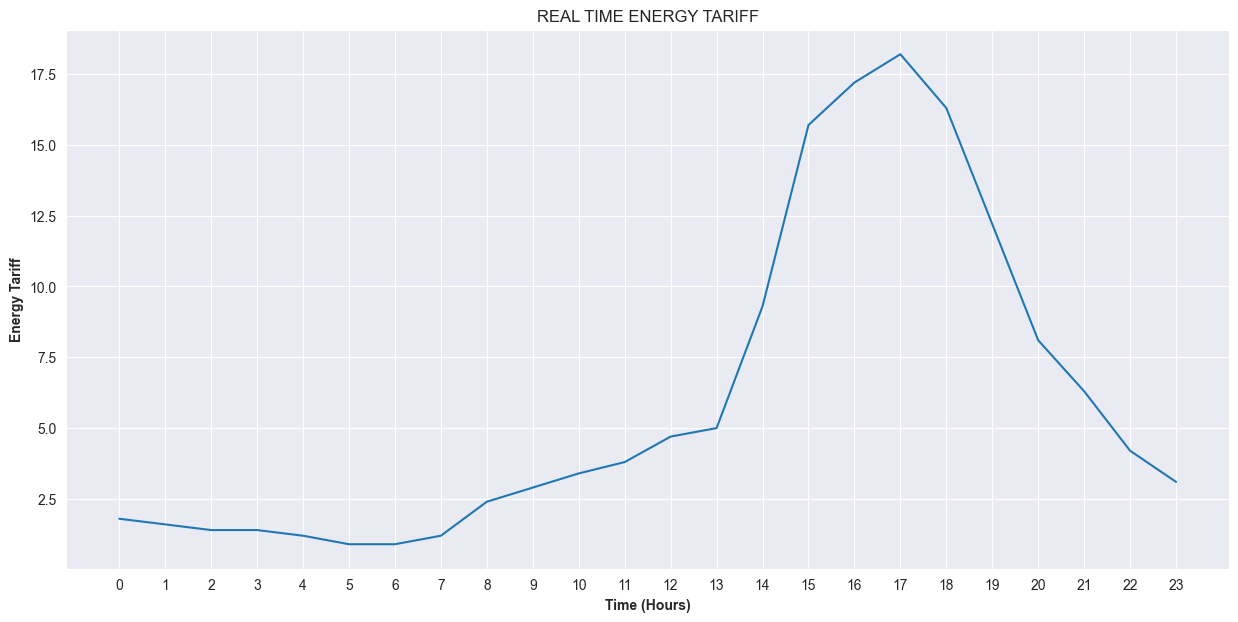

In [111]:
# Real Time Tariff
sns.set_style("dark")
plt.figure(figsize=(15, 7))
plt.plot(np.arange(24), real_time_tariff)
plt.xlabel('Time (Hours)', fontweight='bold')
plt.ylabel('Energy Tariff', fontweight='bold')
plt.title('REAL TIME ENERGY TARIFF')
plt.xticks(np.arange(24))
plt.grid(True)

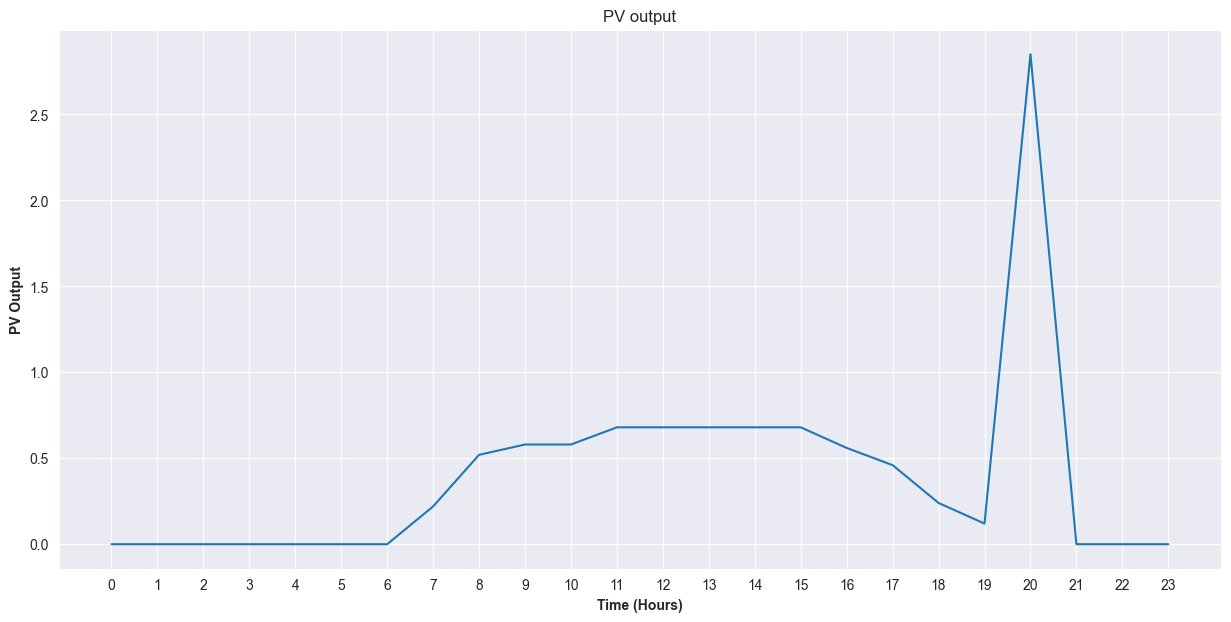

In [113]:
# Microgrid
e_pv_after_charging_battery = np.array([0, 0, 0, 0, 0, 0, 0, 0.22, 0.52, 0.58, 0.58, 0.68,
                                            0.68, 0.68, 0.68, 0.68, 0.56, 0.46, 0.24, 0.12, 2.85, 0, 0, 0])

sns.set_style("dark")
plt.figure(figsize=(15, 7))
plt.plot(np.arange(24), e_pv_after_charging_battery)
plt.xlabel('Time (Hours)', fontweight='bold')
plt.ylabel('PV Output', fontweight='bold')
plt.title('PV output')
plt.xticks(np.arange(24))
plt.grid(True)

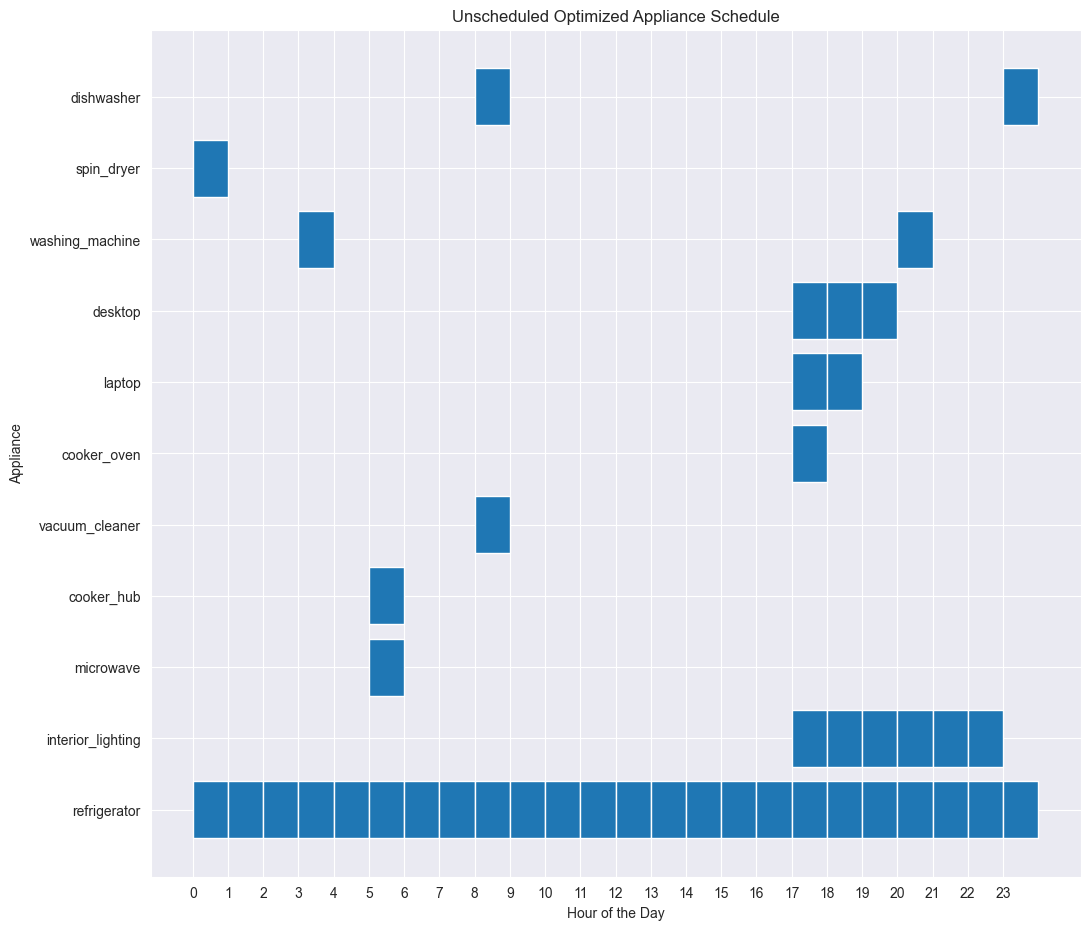

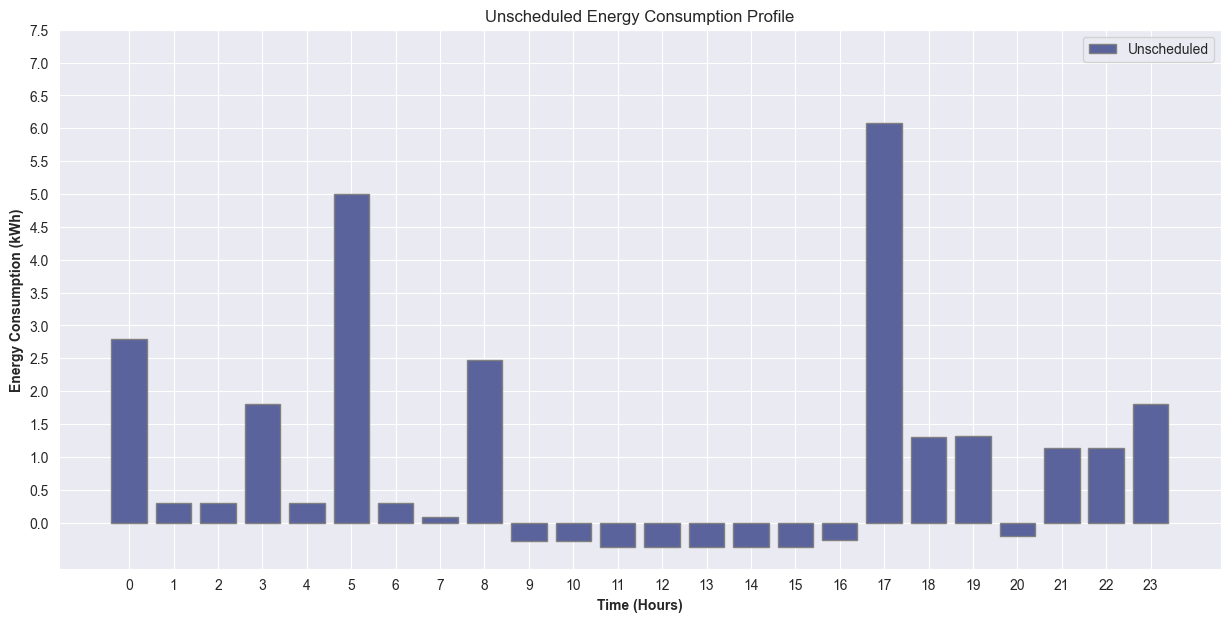

Unscheduled total energy consumption: 23.209999999999997
Unscheduled total cost: 162.57099999999994
Unscheduled PAR: 6.286945282205946


In [101]:
# UNSCHEDULED
plot_schedule(scheduler.NORMAL_STATES, algorithm_name='Unscheduled')

# Energy Profile
plot_unscheduled_energy_consumption(unscheduled_energy_consumption)

# Parameters
print("Unscheduled total energy consumption:", np.sum(unscheduled_energy_consumption))
print("Unscheduled total cost:", unscheduled_cost)
print("Unscheduled PAR:", np.max(unscheduled_energy_consumption)/np.mean(unscheduled_energy_consumption))

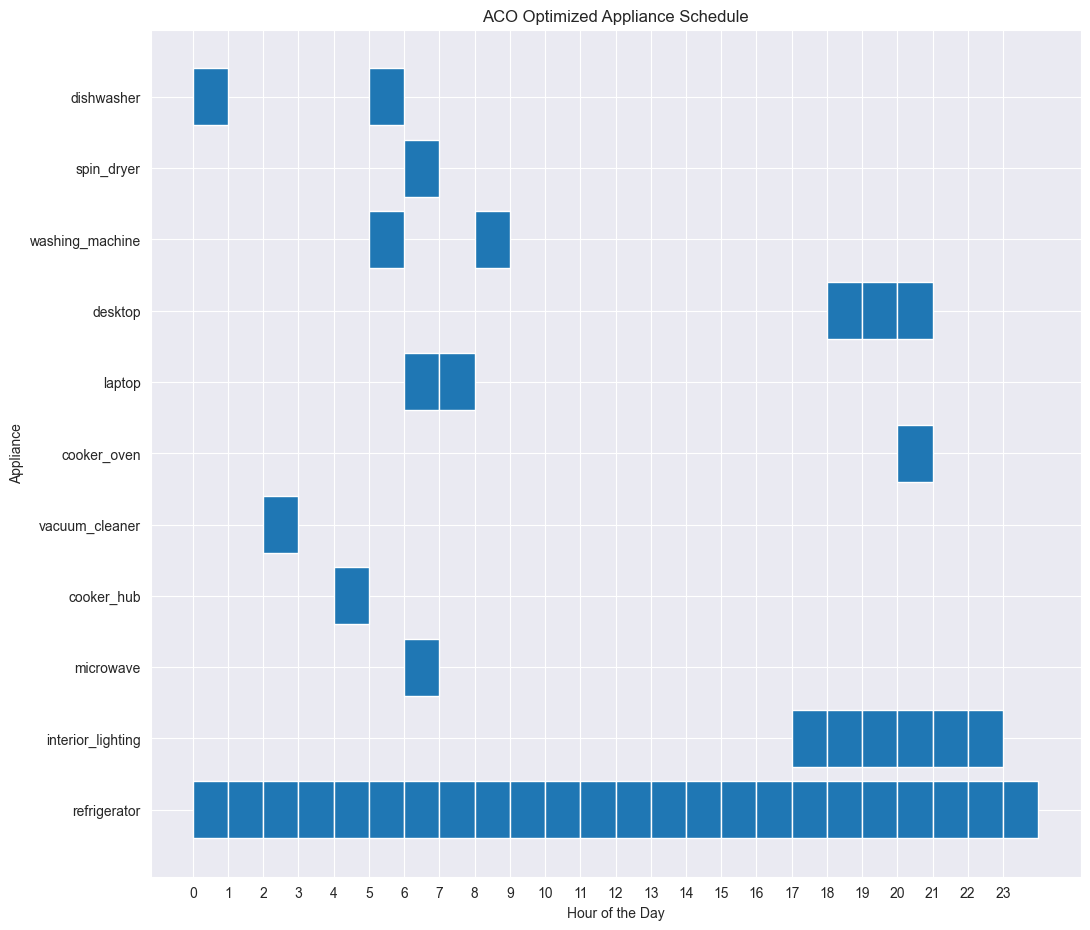

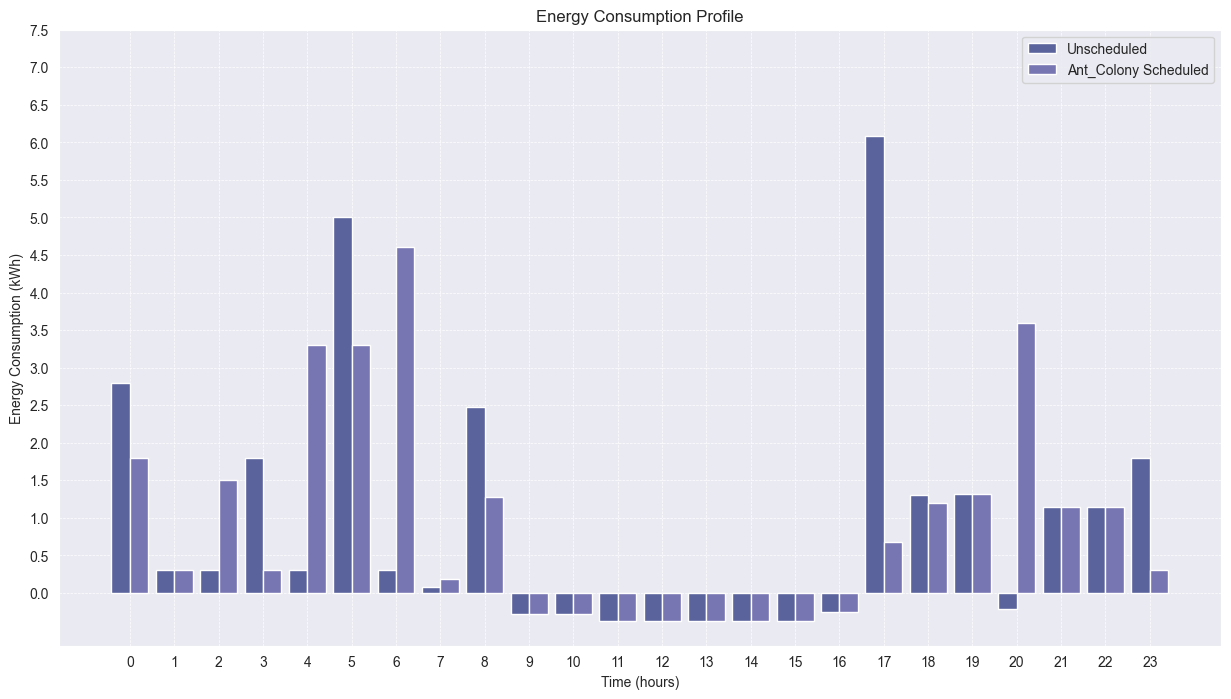

ACO Scheduled discomfort: 9
ACO scheduled total energy consumption: 23.21
ACO scheduled total cost: 89.75099999999999
ACO scheduled PAR: 4.756570443774234


In [102]:
# ANT COLONY OPTIMIZATION

# Schedule
plot_schedule(aco_best_schedule, algorithm_name='ACO')

# Energy Profile
plot_energy_consumption(unscheduled=unscheduled_energy_consumption,
                        output=aco_scheduled_energy_consumption,
                        algo_name="Ant_Colony")

# Parameters
print("ACO Scheduled discomfort:", aco_discomfort_value)
print("ACO scheduled total energy consumption:", np.sum(aco_scheduled_energy_consumption))
print("ACO scheduled total cost:", aco_scheduled_cost)
print("ACO scheduled PAR:", np.max(aco_scheduled_energy_consumption) / np.mean(aco_scheduled_energy_consumption))


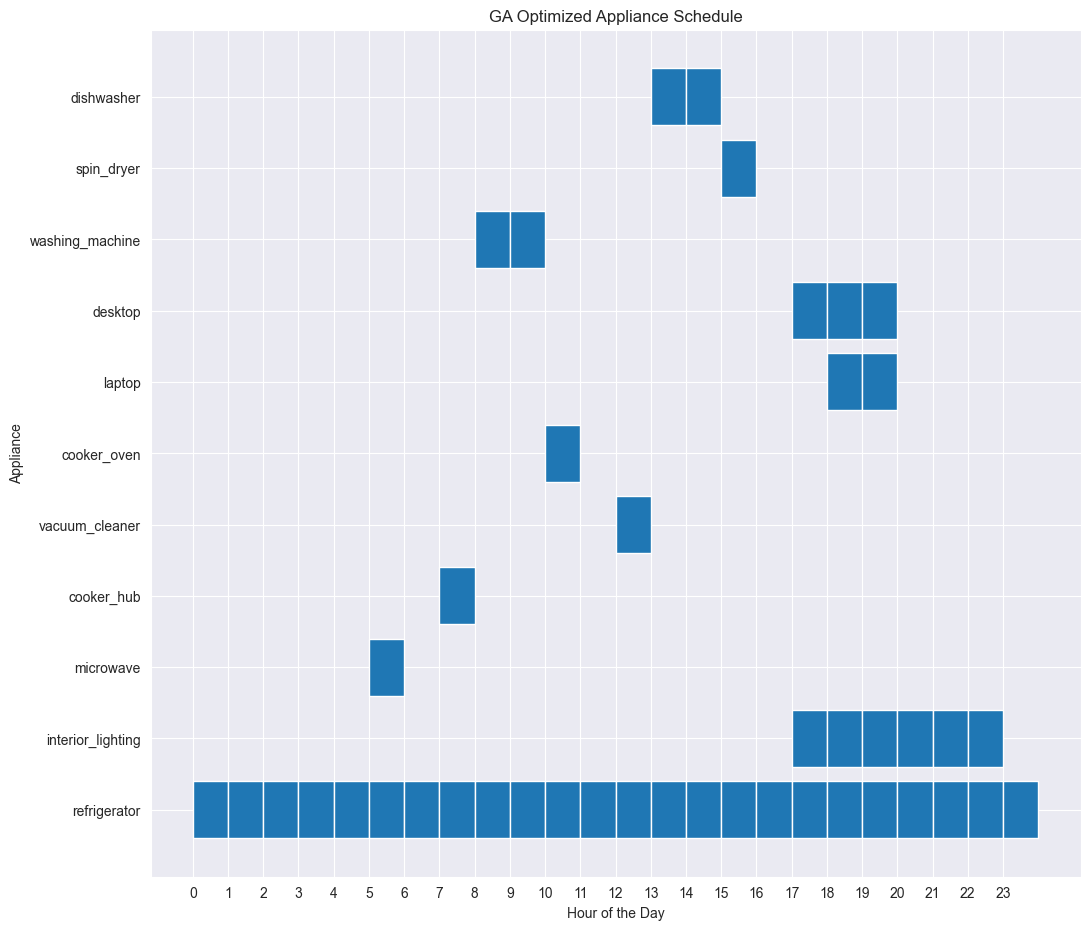

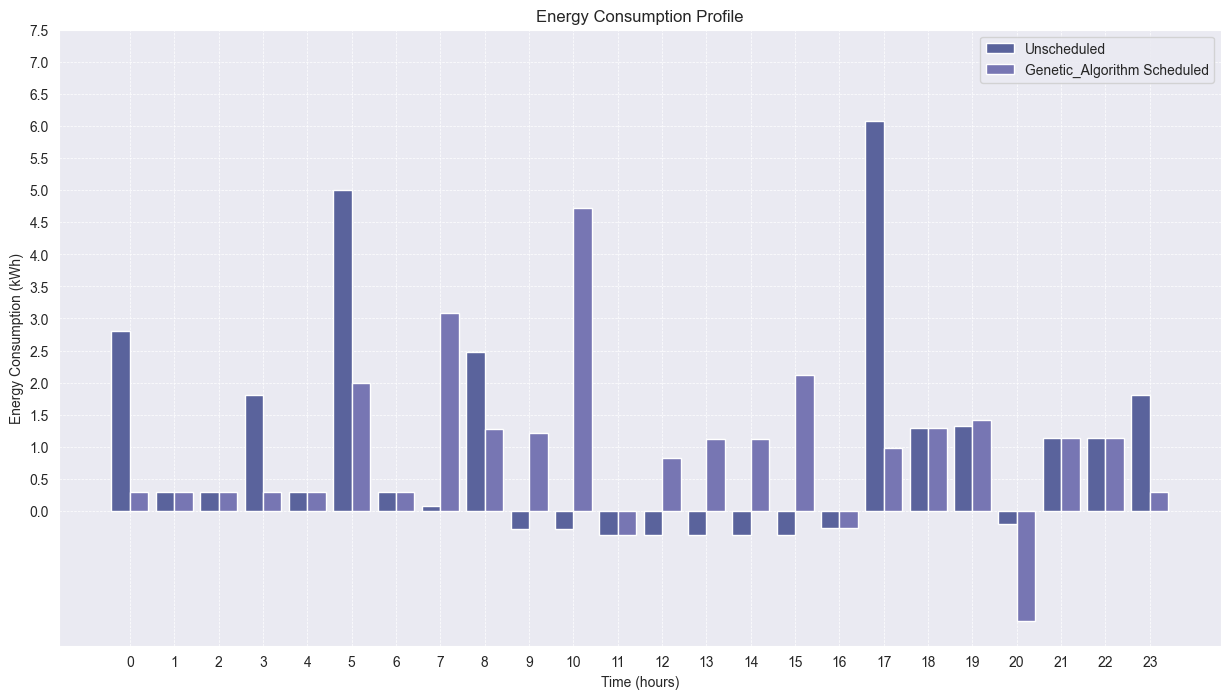

GA Scheduled discomfort: 1
GA scheduled total energy consumption: 23.21
GA scheduled total cost: 133.28099999999998
GA scheduled PAR: 4.880654890133562


In [103]:
# GENETIC ALGORITHM

# Schedule
plot_schedule(ga_best_schedule, algorithm_name='GA')

# Energy Profile
plot_energy_consumption(unscheduled=unscheduled_energy_consumption,
                        output=ga_scheduled_energy_consumption,
                        algo_name="Genetic_Algorithm")

# Parameters
print("GA Scheduled discomfort:", ga_discomfort_value)
print("GA scheduled total energy consumption:", np.sum(ga_scheduled_energy_consumption))
print("GA scheduled total cost:", ga_scheduled_cost)
print("GA scheduled PAR:", np.max(ga_scheduled_energy_consumption)/np.mean(ga_scheduled_energy_consumption))

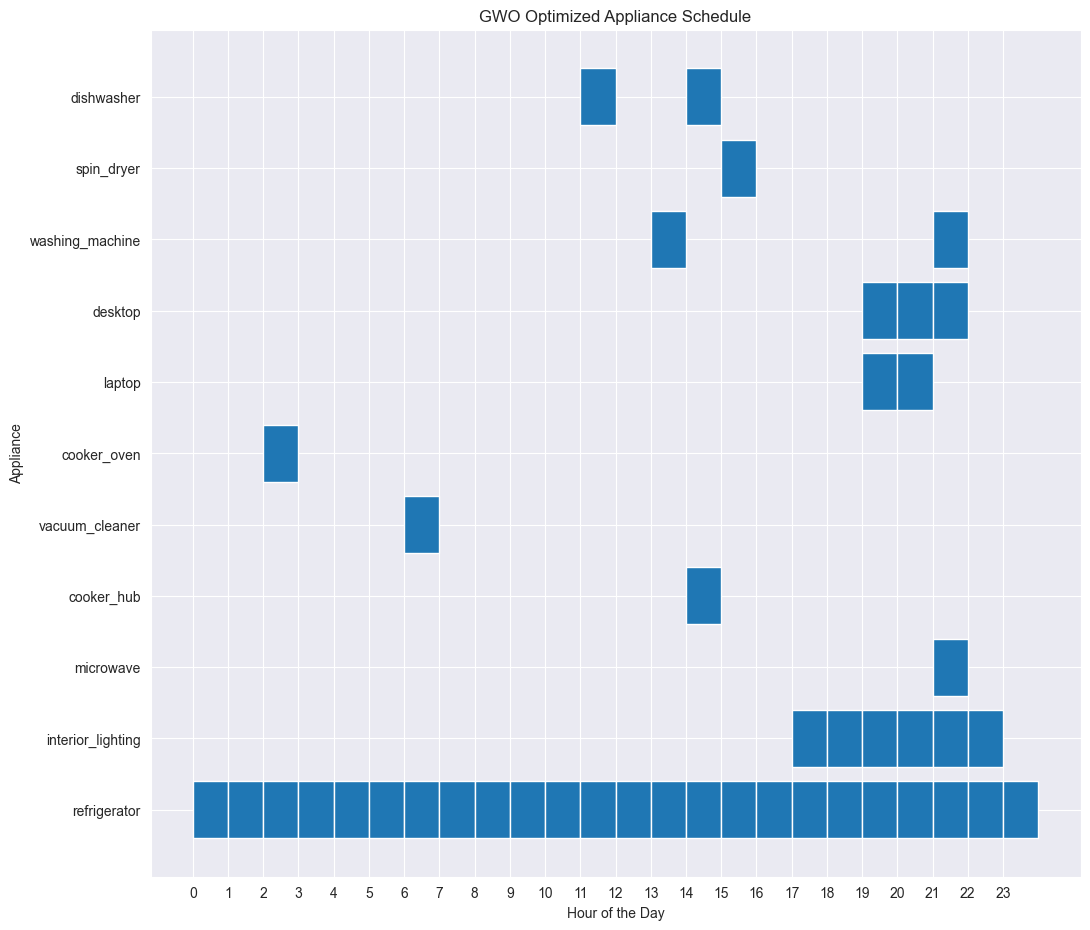

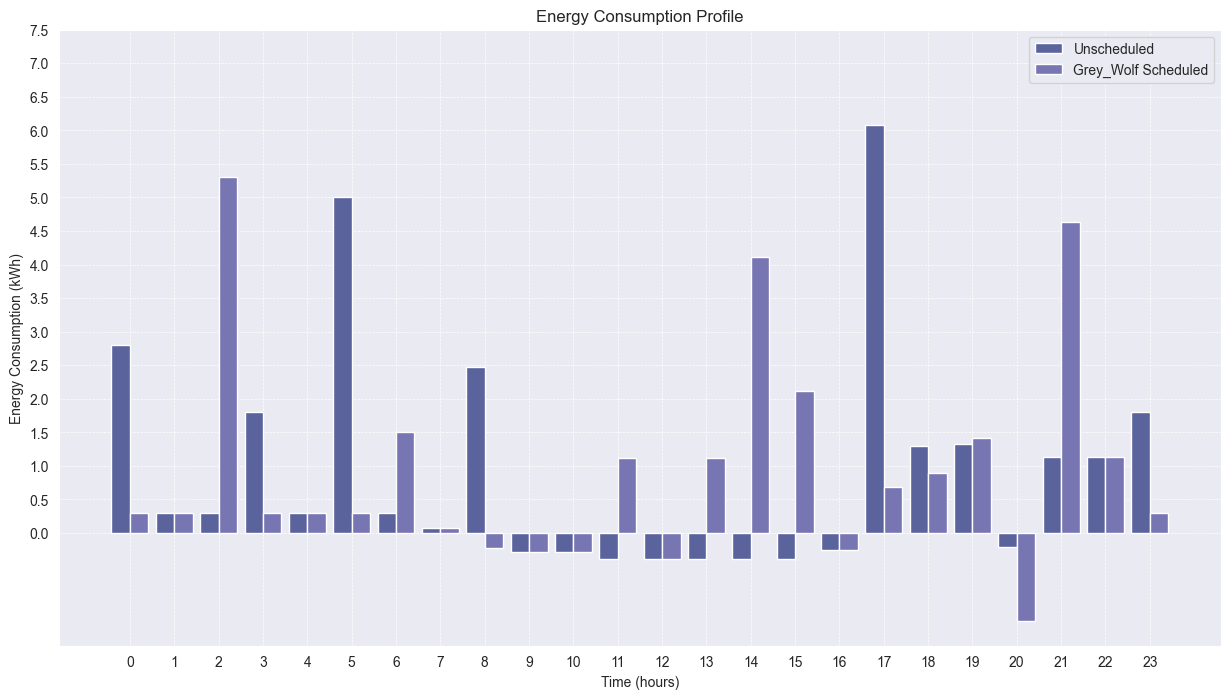

GWO Scheduled discomfort: 6
GWO scheduled total energy consumption: 23.21
GWO scheduled total cost: 152.551
GWO scheduled PAR: 5.480396380870314


In [104]:
# GREY-WOLF OPTIMIZATION

# Schedule
plot_schedule(gwo_best_schedule, algorithm_name='GWO')

# Energy Profile
plot_energy_consumption(unscheduled=unscheduled_energy_consumption,
                        output=gwo_scheduled_energy_consumption,
                        algo_name="Grey_Wolf")

# Parameters
print("GWO Scheduled discomfort:", gwo_discomfort_value)
print("GWO scheduled total energy consumption:", np.sum(gwo_scheduled_energy_consumption))
print("GWO scheduled total cost:", gwo_scheduled_cost)
print("GWO scheduled PAR:", np.max(gwo_scheduled_energy_consumption) / np.mean(gwo_scheduled_energy_consumption))

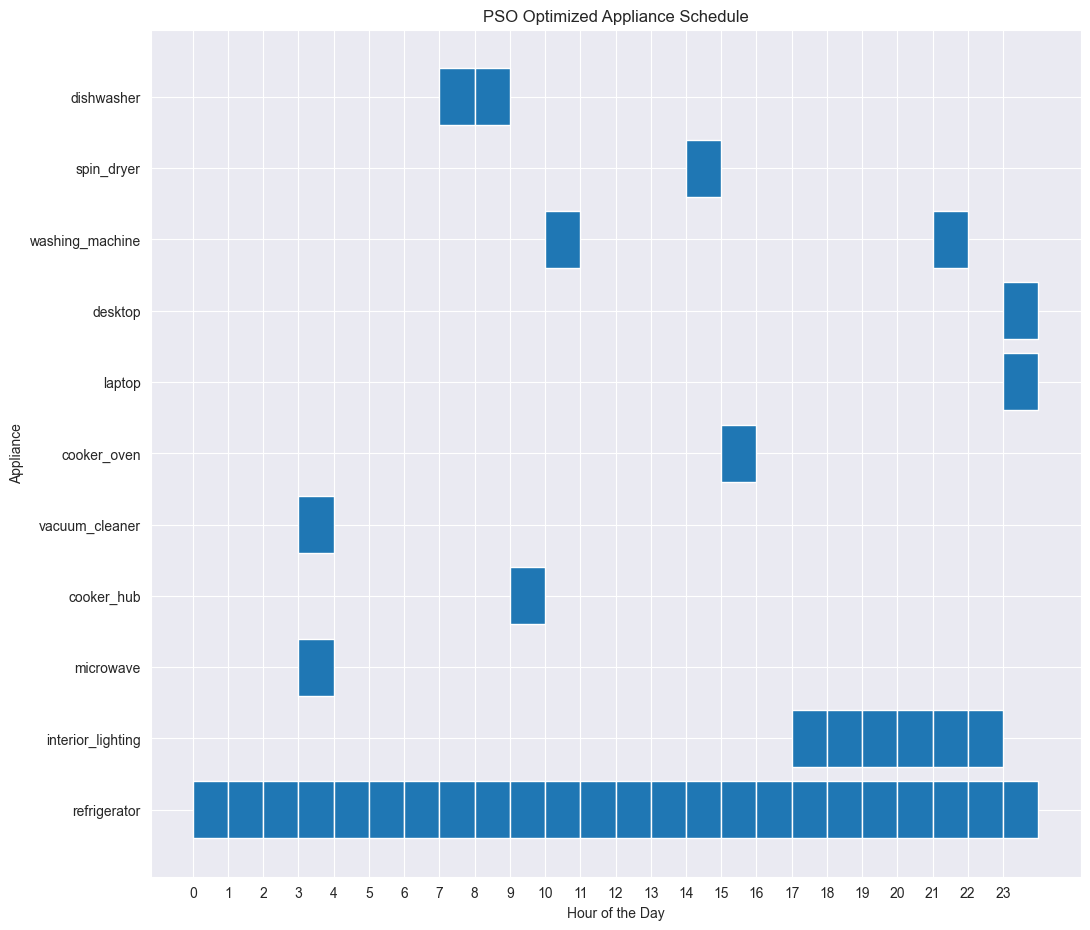

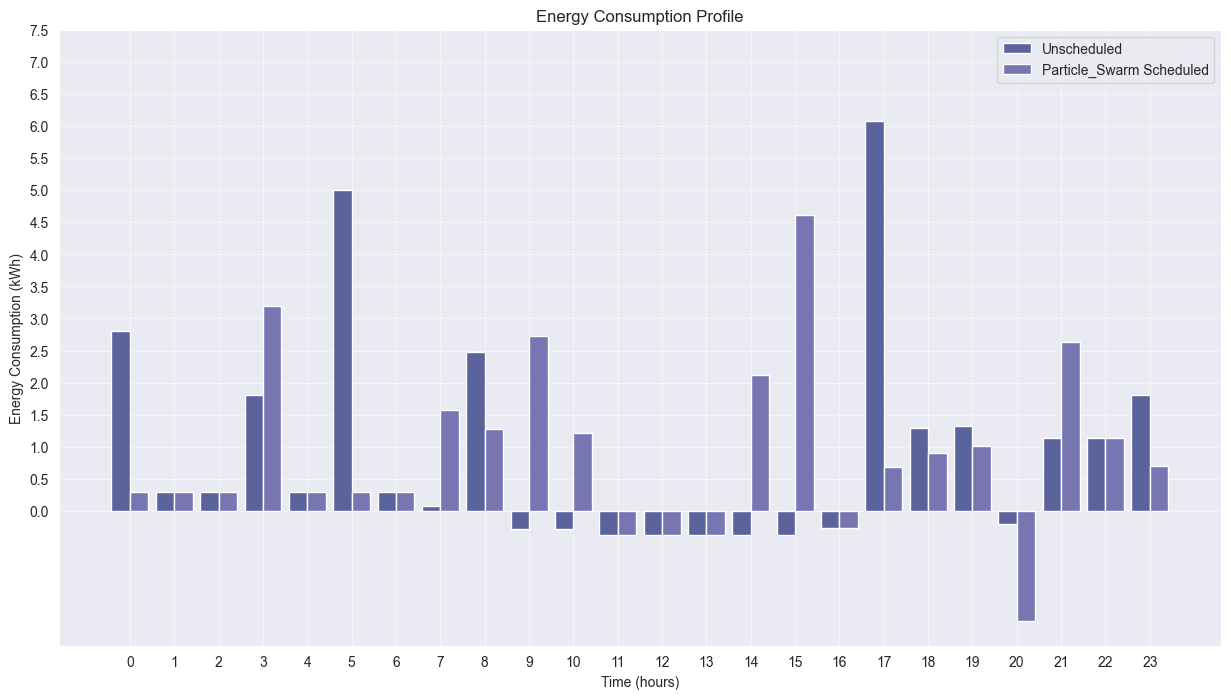

PSO Scheduled discomfort: 5
PSO scheduled total energy consumption: 22.509999999999998
PSO scheduled total cost: 155.70099999999996
PSO scheduled PAR: 4.9258107507774325


In [105]:
# PARTICLE SWARM OPTIMIZATION

# Schedule
plot_schedule(pso_best_schedule, algorithm_name='PSO')

# Energy Profile
plot_energy_consumption(unscheduled=unscheduled_energy_consumption,
                        output=pso_scheduled_energy_consumption,
                        algo_name="Particle_Swarm")

# Parameters
print("PSO Scheduled discomfort:", pso_discomfort_value)
print("PSO scheduled total energy consumption:", np.sum(pso_scheduled_energy_consumption))
print("PSO scheduled total cost:", pso_scheduled_cost)
print("PSO scheduled PAR:", np.max(pso_scheduled_energy_consumption) / np.mean(pso_scheduled_energy_consumption))


**HYBRID ALGORITHM**


In [121]:
class HybridGAPSO:
    def __init__(self, appliances, normal_states, population_size=100, generations=200, c1=1.5, c2=1.5, w=0.7, 
                 crossover_rate=0.8, mutation_rate=0.2):
        self.appliances = appliances
        self.normal_states = normal_states
        self.population_size = population_size
        self.generations = generations
        self.c1 = c1  # Cognitive parameter
        self.c2 = c2  # Social parameter
        self.w = w    # Inertia weight
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = [self.generate_individual() for _ in range(self.population_size)]
        self.velocities = [self.initialize_velocity() for _ in range(self.population_size)]
        self.personal_best = self.population.copy()
        self.global_best = min(self.population, key=self.fitness)
        self.max_power = 4.5  # Maximum power constraint (kW)
        self.max_discomfort = 2  # Maximum discomfort constraint
        self.daily_power_limits = self.set_daily_power_limits()
        self.real_time_tariff = np.array([1.8, 1.6, 1.4, 1.4, 1.2, 0.9, 0.9, 1.2, 2.4, 2.9, 3.4, 3.8, 4.7, 5,
                                          9.3, 15.7, 17.2, 18.2, 16.3, 12.2, 8.1, 6.3, 4.2, 3.1])

    def set_daily_power_limits(self):
        return {device: data[0] * data[1] * 1.1 for category, devices in self.appliances.items() for device, data in
                devices.items()}

    def generate_individual(self):
        individual = {}
        for category, devices in self.appliances.items():
            for device in devices:
                states_of_devices = np.zeros(24, dtype=int)
                data = devices[device]
                length_of_operation = int(data[1])
                user_preferred_start_time = int(data[2])

                if category == "fixed":
                    start_time = user_preferred_start_time
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                elif category == "shiftable":
                    start_time = random.randint(0, 23 - length_of_operation)
                    end_time = start_time + length_of_operation
                    states_of_devices[start_time:end_time] = 1
                else:
                    time_slot = random.sample(range(0, 24), length_of_operation)
                    states_of_devices[time_slot] = 1

                individual[device] = states_of_devices
        return individual

    def initialize_velocity(self):
        return {device: np.random.uniform(-1, 1, 24) for device in self.appliances["fixed"].keys() |
                self.appliances["shiftable"].keys() |
                self.appliances["interruptible"].keys()}

    def energy_cost(self, individual):
        real_time_tariff = np.array([1.8, 1.6, 1.4, 1.4, 1.2, 0.9, 0.9, 1.2, 2.4, 2.9, 3.4, 3.8, 4.7, 5,
                                          9.3, 15.7, 17.2, 18.2, 16.3, 12.2, 8.1, 6.3, 4.2, 3.1])
        demands_from_grid, __ = calculate_energy_consumption(schedule=individual, appliances=self.appliances)
        return np.sum(demands_from_grid * real_time_tariff)

    def discomfort(self, individual):
        discomfort = 0
        for category, devices in self.appliances.items():
            for device in devices:
                data = devices[device]
                user_preferred_start_time = int(data[2])
                user_preferred_end_time = int(data[3])

                for app, states in individual.items():
                    if app == device:
                        for i in range(len(states)):
                            if states[i] == 1 and not (user_preferred_start_time <= i <= user_preferred_end_time):
                                discomfort += 1
        return discomfort

    def constraint_violation(self, individual):
        max_power = 4.5
        max_discomfort = 2
        demands_from_grid, total_power_violation = calculate_energy_consumption(schedule=individual, appliances=self.appliances)
        schedule_discomfort = self.discomfort(individual)
        total_power_violation += np.sum(np.maximum(demands_from_grid - max_power, 0))
        total_discomfort_violation = max(0, schedule_discomfort - max_discomfort)
        return total_power_violation, total_discomfort_violation

    def fitness(self, individual):
        energy_cost = self.energy_cost(individual)
        p_violation, d_violation = self.constraint_violation(individual)

        # Calculate fitness
        fitness = energy_cost

        penalty_factor = 1000
        penalty = p_violation * penalty_factor + d_violation * penalty_factor
        fitness += penalty
        return fitness

    def crossover(self, parent1, parent2):
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()
        child1, child2 = {}, {}
        for device in parent1.keys():
            if random.random() < 0.5:
                child1[device], child2[device] = parent1[device], parent2[device]
            else:
                child1[device], child2[device] = parent2[device], parent1[device]
        return child1, child2

    def mutate(self, individual):
        for device in individual:
            if random.random() < self.mutation_rate:
                if device in self.appliances["shiftable"]:
                    data = self.appliances["shiftable"][device]
                elif device in self.appliances["interruptible"]:
                    data = self.appliances["interruptible"][device]
                else:
                    continue  # Skip fixed appliances

                length_of_operation = int(data[1])
                start_time = random.randint(int(data[2]), int(data[3]) - length_of_operation)
                individual[device] = np.zeros(24, dtype=int)
                individual[device][start_time:start_time+length_of_operation] = 1
        return individual

    def update_velocity(self, particle, velocity):
        for device in velocity:
            r1, r2 = random.random(), random.random()
            # cognitive = self.c1 * r1 * (self.personal_best[self.population.index(particle)][device] - particle[device])
            social = self.c2 * r2 * (self.global_best[device] - particle[device])
            velocity[device] = self.w * velocity[device] + social
        return velocity

    def update_position(self, particle, velocity):
        for device in particle:
            category = next(cat for cat, devices in self.appliances.items() if device in devices)
            data = self.appliances[category][device]
            length_of_operation = int(data[1])

            if category != "fixed":
                new_position = particle[device] + velocity[device]
                new_position = np.clip(new_position, 0, 1)

                if category == "shiftable":
                    start_time = np.argmax(new_position)
                    particle[device] = np.zeros(24, dtype=int)
                    end_time = min(start_time + length_of_operation, 24)
                    particle[device][start_time:end_time] = 1
                elif category == "interruptible":
                    top_indices = np.argsort(new_position)[-length_of_operation:]
                    particle[device] = np.zeros(24, dtype=int)
                    particle[device][top_indices] = 1
        return particle

    def run(self):
        for generation in range(self.generations):
            # PSO part
            for i, particle in enumerate(self.population):
                self.velocities[i] = self.update_velocity(particle, self.velocities[i])
                self.population[i] = self.update_position(particle, self.velocities[i])

                fitness = self.fitness(self.population[i])
                if fitness < self.fitness(self.personal_best[i]):
                    self.personal_best[i] = self.population[i].copy()

                if fitness < self.fitness(self.global_best):
                    self.global_best = self.population[i].copy()

            # GA part
            next_generation = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = random.choices(self.population, k=2)
                child1, child2 = self.crossover(parent1, parent2)
                next_generation.extend([self.mutate(child1), self.mutate(child2)])

            self.population = next_generation

            # Update global best
            best_individual = min(self.population, key=self.fitness)
            if self.fitness(best_individual) < self.fitness(self.global_best):
                self.global_best = best_individual.copy()

        return self.global_best


In [122]:
# running

# Hybrid GA-PSO scheduling
hybrid = HybridGAPSO(appliances, scheduler.NORMAL_STATES)
hybrid_best_schedule = hybrid.run()
hybrid_scheduled_energy_consumption, _ = calculate_energy_consumption(hybrid_best_schedule, appliances)
hybrid_discomfort_value = hybrid.discomfort(hybrid_best_schedule)
hybrid_scheduled_cost = np.sum(hybrid_scheduled_energy_consumption * real_time_tariff)


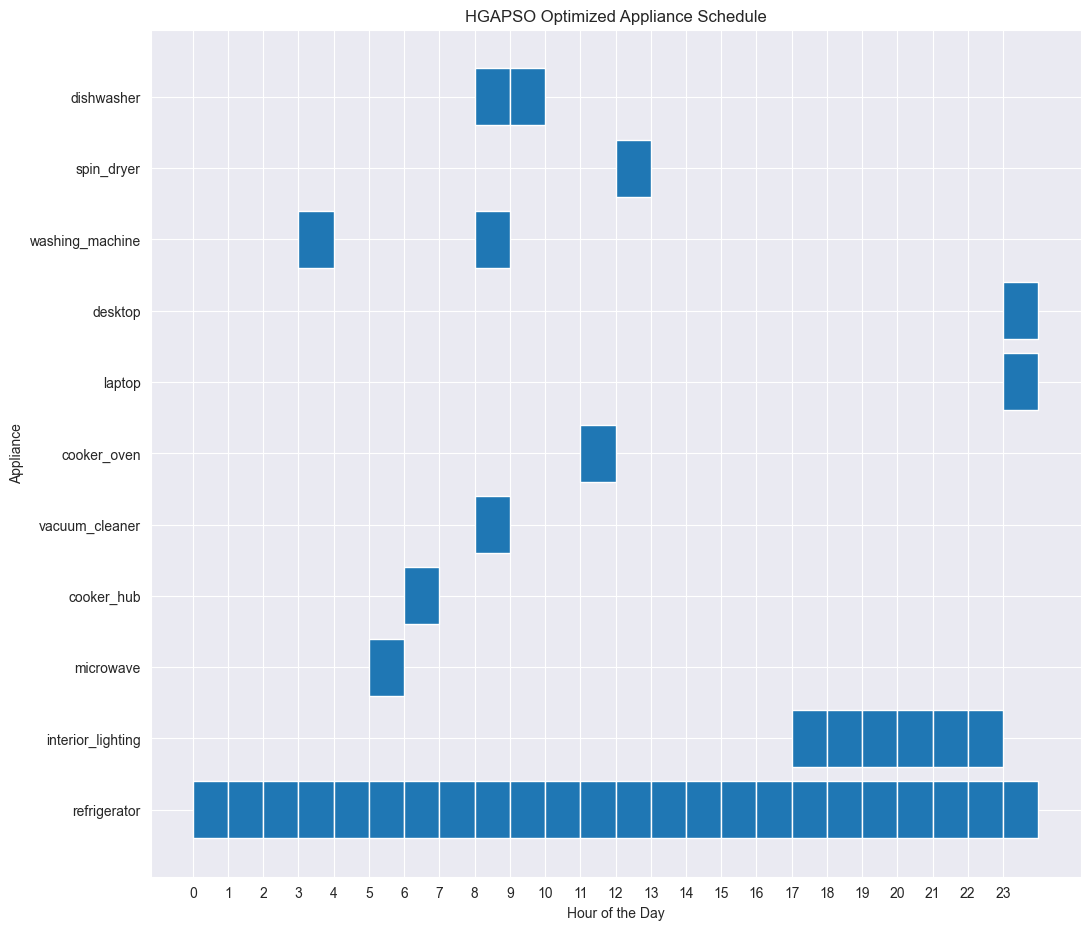

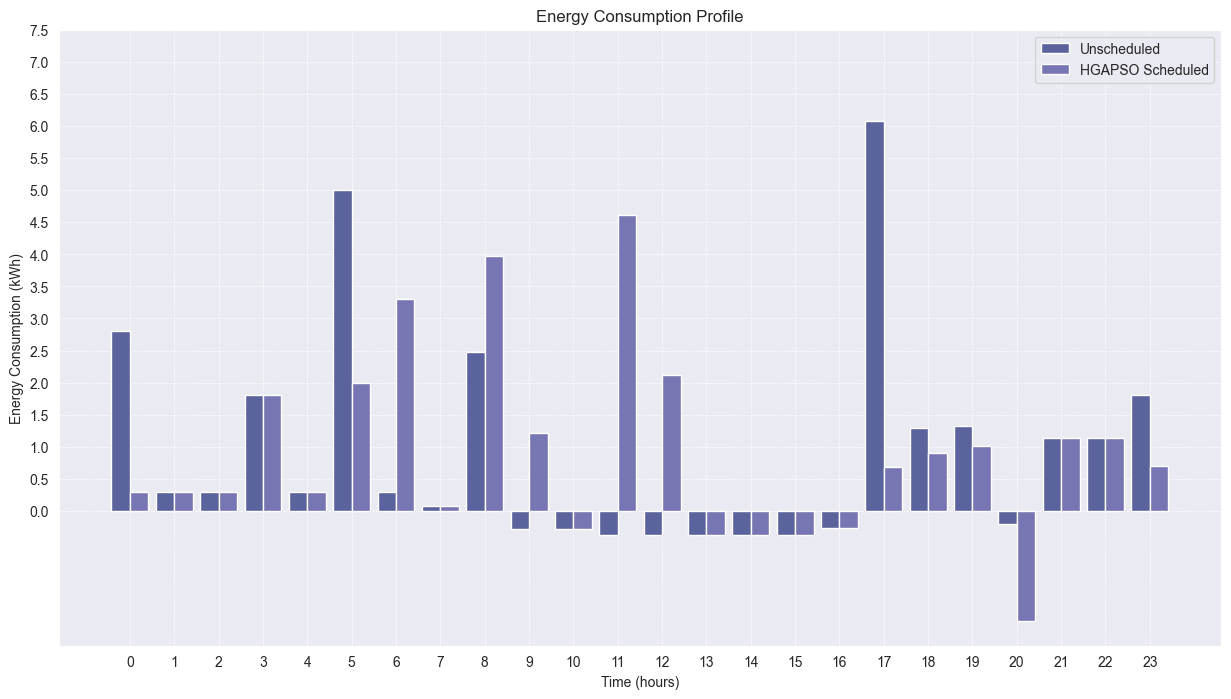

HGAPSO Scheduled discomfort: 2
HGAPSO scheduled total energy consumption: 22.509999999999998
HGAPSO scheduled total cost: 72.75099999999999
HGAPSO scheduled PAR: 4.9258107507774325


In [123]:
# Schedule
plot_schedule(hybrid_best_schedule, algorithm_name='HGAPSO')

# Energy Profile
plot_energy_consumption(unscheduled=unscheduled_energy_consumption,
                        output=hybrid_scheduled_energy_consumption,
                        algo_name="HGAPSO")

# Parameters
print("HGAPSO Scheduled discomfort:", hybrid_discomfort_value)
print("HGAPSO scheduled total energy consumption:", np.sum(hybrid_scheduled_energy_consumption))
print("HGAPSO scheduled total cost:", hybrid_scheduled_cost)
print("HGAPSO scheduled PAR:", np.max(hybrid_scheduled_energy_consumption) / np.mean(hybrid_scheduled_energy_consumption))

**COMPARISON OF PARAMETERS**


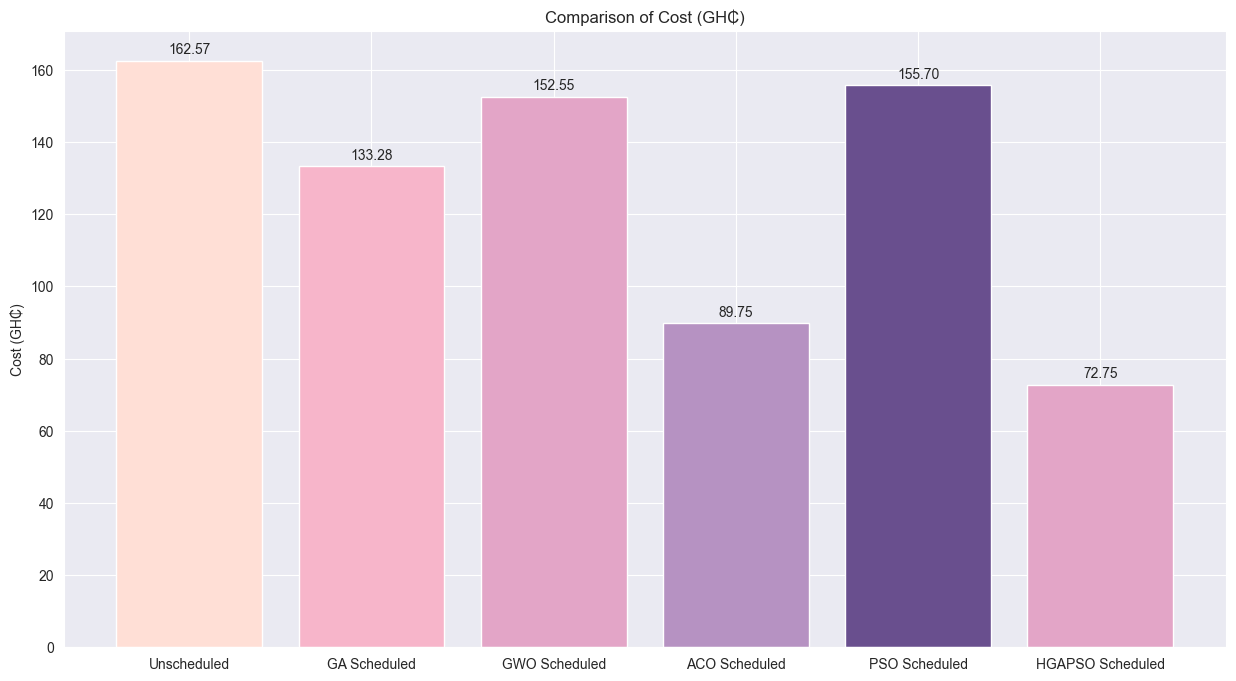

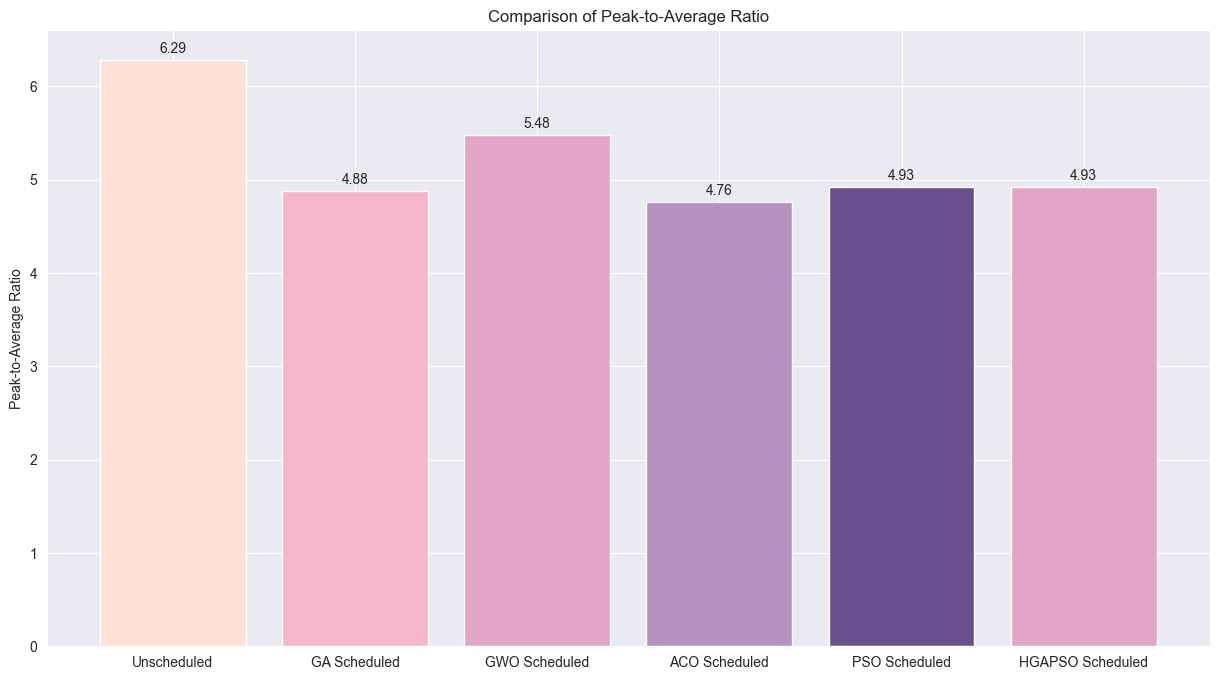

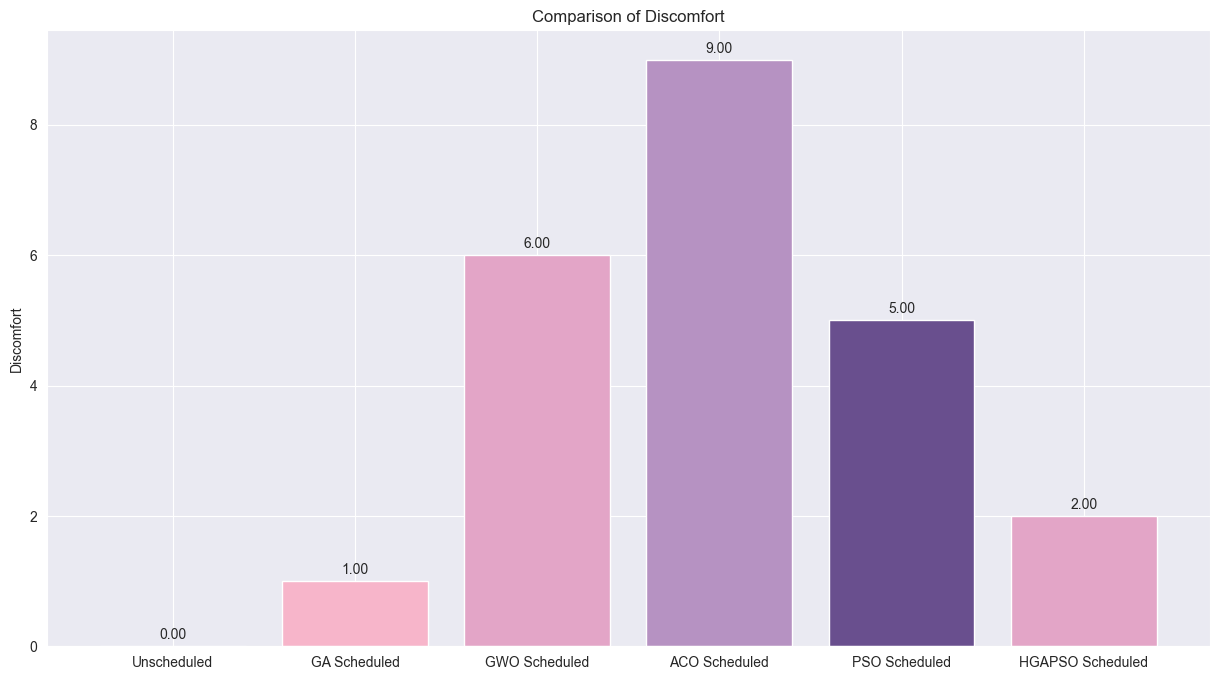

In [130]:
ga_scheduled_par = np.max(ga_scheduled_energy_consumption)/np.mean(ga_scheduled_energy_consumption)
pso_scheduled_par = np.max(pso_scheduled_energy_consumption) / np.mean(pso_scheduled_energy_consumption)
gwo_scheduled_par = np.max(gwo_scheduled_energy_consumption) / np.mean(gwo_scheduled_energy_consumption)
aco_scheduled_par = np.max(aco_scheduled_energy_consumption) / np.mean(aco_scheduled_energy_consumption)
hybrid_scheduled_par = np.max(hybrid_scheduled_energy_consumption) / np.mean(hybrid_scheduled_energy_consumption)
unscheduled_par = np.max(unscheduled_energy_consumption)/np.mean(unscheduled_energy_consumption)
unscheduled_discomfort_value = 0

values = {
        'Unscheduled': [unscheduled_cost, unscheduled_par, unscheduled_discomfort_value],
        'GA Scheduled': [ga_scheduled_cost, ga_scheduled_par, ga_discomfort_value],
        'GWO Scheduled': [gwo_scheduled_cost, gwo_scheduled_par, gwo_discomfort_value],
        'ACO Scheduled': [aco_scheduled_cost, aco_scheduled_par, aco_discomfort_value],
        'PSO Scheduled': [pso_scheduled_cost, pso_scheduled_par, pso_discomfort_value],
        'HGAPSO Scheduled': [hybrid_scheduled_cost, hybrid_scheduled_par, hybrid_discomfort_value],
    }

parameter_names = ['Cost (GH₵)', 'Peak-to-Average Ratio', 'Discomfort']

plot_comparison(data=values, parameter_names=parameter_names)
